In [1]:
import os
import pickle
import numpy as np
import gensim
import wandb
from typing import List
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pathlib import Path
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from opencc import OpenCC
from tokenizers import Tokenizer
from utils.custom_tokenizer import load_jieba_tokenizer, load_janome_tokenizer

os.environ["TOKENIZERS_PARALLELISM"] = "False"
%matplotlib inline

In [2]:
cc = OpenCC("t2s")

In [3]:
run = wandb.init(project='phonetic-translation', 
                 entity='windsuzu',
                 group="word2vec",
                 job_type="analyze",
                 reinit=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: windsuzu (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Loading Gensim Embeddings

In [4]:
word2vec_art = run.use_artifact("language_specific_word2vec:latest")
word2vec_dir = word2vec_art.download()

ch_word2vec_dir = Path(word2vec_dir) / "ch.word2vec"
chp_word2vec_dir = Path(word2vec_dir) / "chp.word2vec"
jp_word2vec_dir = Path(word2vec_dir) / "jp.word2vec"
jpp_word2vec_dir = Path(word2vec_dir) / "jpp.word2vec"

wandb: Downloading large artifact language_specific_word2vec:latest, 254.19MB. 4 files... Done. 0:0:0


In [5]:
ch_word2vec = Word2Vec.load(str(ch_word2vec_dir)).wv
chp_word2vec = Word2Vec.load(str(chp_word2vec_dir)).wv
jp_word2vec = Word2Vec.load(str(jp_word2vec_dir)).wv
jpp_word2vec = Word2Vec.load(str(jpp_word2vec_dir)).wv

In [6]:
job = 1
embedding_job = ["sentencepiece_embedding", "language_specific_embedding"]
tokenizer_job = ["sentencepiece", "language_specific"]

ch_tokenizer_job = ["ch_tokenzier.json", "jieba_tokenizer.json"]
jp_tokenizer_job = ["jp_tokenzier.json", "janome_tokenizer.json"]

In [7]:
embedding_art = run.use_artifact(f"{embedding_job[job]}:latest")
embedding_dir = embedding_art.download()

tokenizer_art = run.use_artifact(f"{tokenizer_job[job]}:latest")
tokenizer_dir = tokenizer_art.download()

wandb: Downloading large artifact language_specific_embedding:latest, 732.42MB. 8 files... Done. 0:0:0


In [8]:
def load_ch_tokenizer(job):
    path = Path(tokenizer_dir) / ch_tokenizer_job[job]
    return Tokenizer.from_file(str(path)) if job == 0 else load_jieba_tokenizer(path)


def load_jp_tokenizer(job):
    path = Path(tokenizer_dir) / jp_tokenizer_job[job]
    return Tokenizer.from_file(str(path)) if job == 0 else load_janome_tokenizer(path)


ch_tokenizer = load_ch_tokenizer(job)
jp_tokenizer = load_jp_tokenizer(job)

chm_embedding = np.load(Path(embedding_dir) / "ch_meta_embedding.npy")
jpm_embedding = np.load(Path(embedding_dir) / "jp_meta_embedding.npy")

In [9]:
def create_meta_word2vec(tokenizer, embedding, vocab_size, vector_size):
    vocab = [None]*vocab_size
    for k, i in tokenizer.get_vocab().items():
        vocab[i] = k
    
    mixed_word2vec = KeyedVectors(vector_size)
    mixed_word2vec.add_vectors(vocab, embedding)
    
    return mixed_word2vec
    
chm_word2vec = create_meta_word2vec(ch_tokenizer, chm_embedding, 32000, 300)
jpm_word2vec = create_meta_word2vec(jp_tokenizer, jpm_embedding, 32000, 300)

# Visaulize Vectors

In [10]:
import pandas as pd
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
plt.rcParams['axes.unicode_minus'] = False

In [11]:
def create_embedding_heatmap(word2vec, words: List[str], features=20, is_zh=True):
    assert 300 % features == 0, "embedding dim does not fit the number of features"
    
    if is_zh:
        words = list(map(cc.convert, words))
    
    new_features = [
        word2vec[word].reshape(-1, 300 // features).mean(axis=1) for word in words
    ]
    feature_map = pd.DataFrame(data=new_features, index=words)

    plt.figure(figsize=(20, 6))
    sns.set(font_scale=1.3)

    plt.rcParams['legend.frameon'] = True
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
    plt.rcParams['axes.unicode_minus'] = False
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(
        feature_map,
        cmap=cmap,
        vmax=.1,
        center=0,
        square=True,
        linewidths=0.5,
        xticklabels=False,
        cbar_kws={"shrink": 0.5},
    )
    
    h = sns.heatmap(
        feature_map.T.corr(),
        cmap=cmap,
        cbar=False,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )
    h.set_yticklabels(h.get_yticklabels(), rotation=0)
    h.set_xticklabels(h.get_xticklabels(), rotation=0)

In [12]:
def create_embedding_corr(word2vec1, word2vec2, words: List[str], features=300, is_zh=True, filename=None):
    assert 300 % features == 0, "embedding dim does not fit the number of features"
    
    if is_zh:
        words = list(map(cc.convert, words))
    
    features1 = [
        word2vec1[word].reshape(-1, 300 // features).mean(axis=1) for word in words
    ]
    features2 = [
        word2vec2[word].reshape(-1, 300 // features).mean(axis=1) for word in words
    ]
    feature_map1 = pd.DataFrame(data=features1, index=words)
    feature_map2 = pd.DataFrame(data=features2, index=words)
    
    plt.figure(figsize=(7, 4))
    sns.set(font_scale=1.5)
    
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
    plt.rcParams['axes.unicode_minus'] = False
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    plt.subplot(121)
    plt.title("Semantic Only")
    h1 = sns.heatmap(
        feature_map1.T.corr(),
        cmap=cmap,
        cbar=False,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )
    h1.set_yticklabels(h1.get_yticklabels(), rotation=0)
    h1.set_xticklabels(h1.get_xticklabels(), rotation=0)
    
    plt.subplot(122)
    plt.title("Semantic + Phonetic")
    h2 = sns.heatmap(
        feature_map2.T.corr(),
        cmap=cmap,
        cbar=False,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )
    h2.set_yticklabels(h2.get_yticklabels(), rotation=0)
    # h2.set_xticklabels(h2.get_xticklabels(), rotation=0)
    h2.tick_params(labelleft=False)
    
    plt.savefig(filename)

# Similarity Test

In [13]:
def test_similarity(*words, emb1, emb2, is_zh=True, filename=None, y_max=None, verbose=0):
    if is_zh:
        words = list(map(cc.convert, words))
    distance1 = emb1.distances(words[0], words[1:])
    distance2 = emb2.distances(words[0], words[1:])
    
    plt.style.use("seaborn")
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
    plt.rcParams['axes.unicode_minus'] = False
    
    if y_max:
        plt.ylim(0, y_max)
        
    width = 0.25
    index = np.arange(len(words[1:]))
    plt.bar(index - width, distance1, width=width, label="semantic")
    plt.bar(index, distance2, width=width, label="joint")
    plt.xticks(ticks=index-.1, labels=words[1:], fontsize=24)
    plt.title(f"Distance from {words[0]}", fontsize=24)
    plt.legend(prop={'size': 16})
    plt.tight_layout()
    
    if verbose == 1:
        print(distance1, distance2)
    
    if filename:
        plt.savefig(filename)

## Chinese

Find synonym: https://www.3du.tw/synonym.php

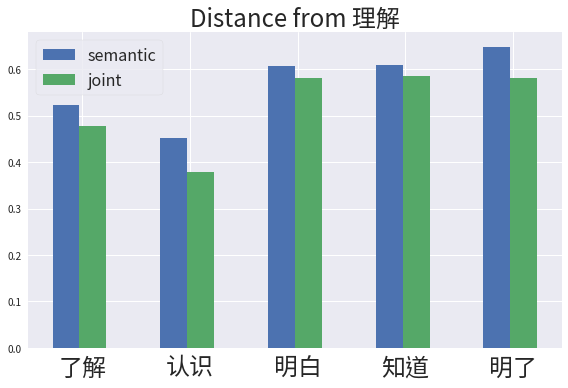

In [14]:
test_similarity("理解", "瞭解", "認識", "明白", "知道", "明瞭", emb1=ch_word2vec, emb2=chm_word2vec, filename="similarity_zh.jpg")

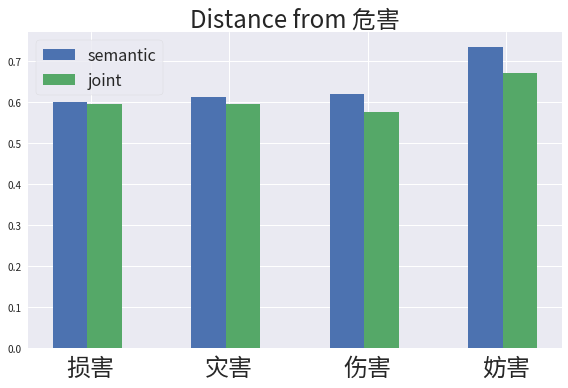

In [15]:
test_similarity("危害", "損害", "災害", "傷害", "妨害", emb1=ch_word2vec, emb2=chm_word2vec)

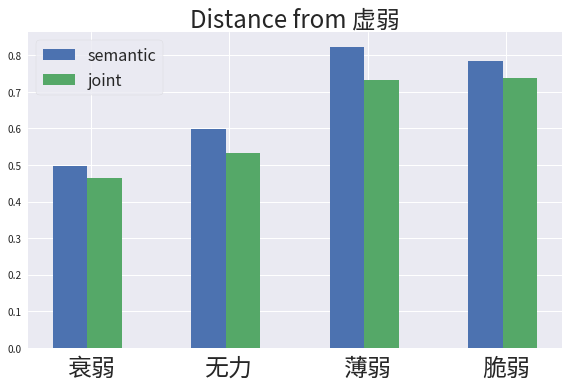

In [16]:
test_similarity("虛弱", "衰弱", "無力", "薄弱", "脆弱", emb1=ch_word2vec, emb2=chm_word2vec)

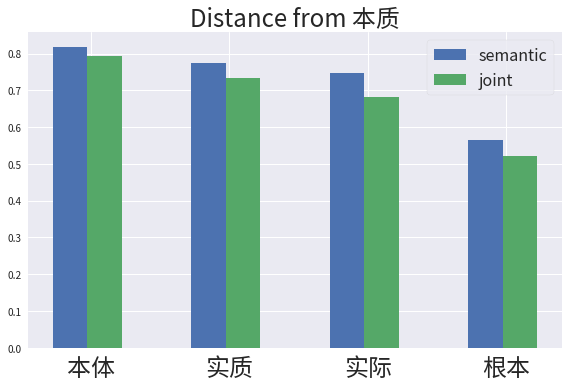

In [17]:
test_similarity("本質", "本體", "實質", "實際", "根本", emb1=ch_word2vec, emb2=chm_word2vec)

## Japanese

find synonym: https://thesaurus.weblio.jp/

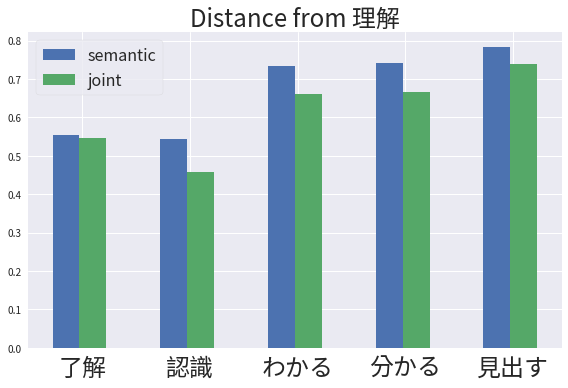

In [18]:
test_similarity("理解", "了解", "認識", "わかる", "分かる", "見出す", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False)

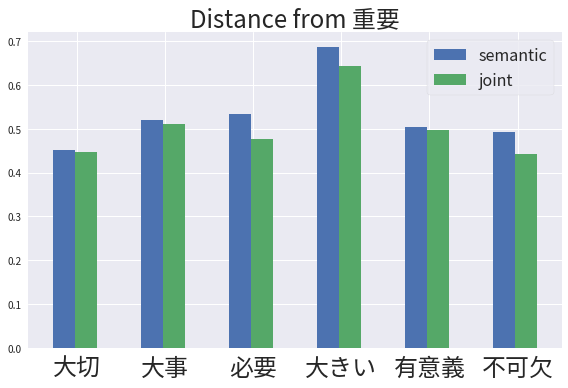

In [19]:
test_similarity("重要", "大切", "大事", "必要", "大きい", "有意義", "不可欠", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False)

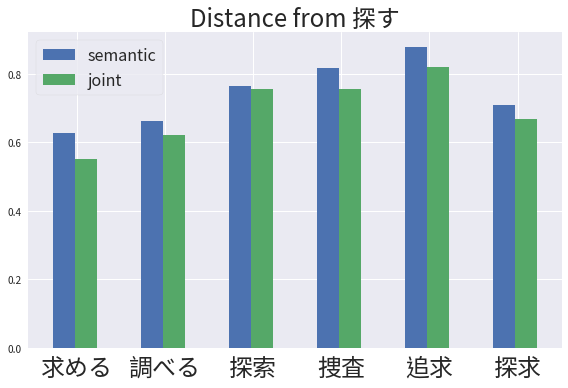

In [20]:
test_similarity("探す", "求める", "調べる", "探索", "捜査", "追求", "探求", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False)

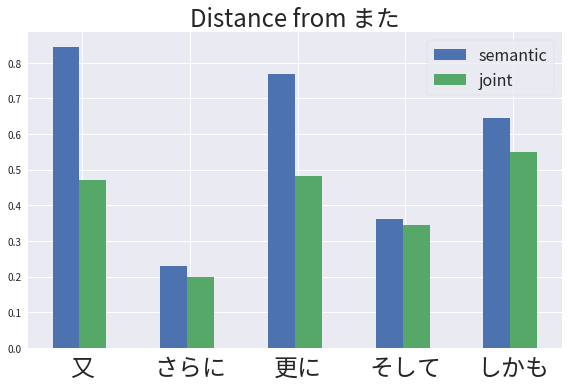

In [21]:
test_similarity("また", "又", "さらに", "更に", "そして", "しかも", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False, filename="similarity_jp.jpg")

# Analogy Test

https://stackoverflow.com/questions/54580260/understanding-gensim-word2vecs-most-similar

In [22]:
def test_analogy(x1, x2, y1, emb1, emb2, is_zh=True, topn=3):
    if is_zh:
        x1, x2, y1 = map(cc.convert, [x1, x2, y1])
    res1 = emb1.most_similar(positive=[x2, y1], negative=[x1], topn=topn)
    res2 = emb2.most_similar(positive=[x2, y1], negative=[x1], topn=topn)
    df = pd.DataFrame([res1, res2], index=["semantic", "joint"])
    return df

## Chinese

In [19]:
test_analogy("東京", "日本", "北京", ch_word2vec, chm_word2vec)

,0,1,2
semantic,"(中国, 0.4918120205402374)","(香港, 0.4542633593082428)","(欧洲, 0.447649210691452)"
joint,"(中国, 0.530601978302002)","(欧洲, 0.4985966086387634)","(美国, 0.4914376139640808)"


In [81]:
test_analogy("長期", "三年", "短期", ch_word2vec, chm_word2vec)

,0,1,2
semantic,"(一年, 0.3793664276599884)","(入学, 0.373923122882843)","(威特, 0.373820960521698)"
joint,"(两周, 0.38714638352394104)","(黑龙江, 0.3845103085041046)","(六个, 0.3709550201892853)"


In [83]:
test_analogy("進口", "買入", "出口", ch_word2vec, chm_word2vec)

,0,1,2
semantic,"(卖出, 0.3636208176612854)","(入口, 0.34043172001838684)","(收取, 0.320338636636734)"
joint,"(卖出, 0.44192928075790405)","(入口, 0.4030747711658478)","(投标人, 0.3964996337890625)"


## Japanese

In [18]:
test_analogy("男性", "女性", "父親", jp_word2vec, jpm_word2vec, is_zh=False)

,0,1,2
semantic,"(母親, 0.4868825674057007)","(赤ちゃん, 0.4835638403892517)","(父母, 0.4637010097503662)"
joint,"(母親, 0.5082985162734985)","(赤ちゃん, 0.4885145425796509)","(夫婦, 0.4501483142375946)"


In [53]:
test_analogy("長期", "年", "短期", jp_word2vec, jpm_word2vec, is_zh=False)

,0,1,2
semantic,"(月, 0.5500056743621826)","(2006, 0.520151674747467)","(2005, 0.509982168674469)"
joint,"(月, 0.569668173789978)","(2005, 0.5362728834152222)","(2006, 0.4921896755695343)"


In [58]:
test_analogy("左右", "前後", "水平", jp_word2vec, jpm_word2vec, is_zh=False)

,0,1,2
semantic,"(垂直, 0.4324204623699188)","(鉛直, 0.3152925670146942)","(短冊, 0.31343212723731995)"
joint,"(垂直, 0.40165072679519653)","(後, 0.363545686006546)","(以内, 0.3538738489151001)"


# Outlier Test

In [23]:
def test_outlier(*words, emb1, emb2, is_zh=True):
    if is_zh:
        words = list(map(cc.convert, words))
    
    assert [emb1[word] is not None for word in words]
    
    out1 = emb1.doesnt_match(words)
    filtered1 = [word for word in words if word != out1]
    
    out2 = emb2.doesnt_match(words)
    filtered2 = [word for word in words if word != out2]
    
    df = pd.DataFrame([[filtered1, out1],
                       [filtered2, out2]], index=["semantic", "joint"], columns=["group", "outlier"])
    return df

## Chinese

In [74]:
test_outlier("維持", "保持", "堅持", "建設", emb1=ch_word2vec, emb2=chm_word2vec)

,group,outlier
semantic,"[维持, 保持, 坚持]",建设
joint,"[维持, 保持, 坚持]",建设


In [87]:
test_outlier("可行", "不行", "可以", "行", emb1=ch_word2vec, emb2=chm_word2vec)

,group,outlier
semantic,"[可行, 不行, 行]",可以
joint,"[可行, 可以, 行]",不行


## Japanese

In [141]:
test_outlier("生み", "創造", "作る", "破壊", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False)

,group,outlier
semantic,"[生み, 創造, 作る]",破壊
joint,"[生み, 創造, 作る]",破壊


In [153]:
test_outlier("普通", "一般", "通常", "異常", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False)

,group,outlier
semantic,"[普通, 一般, 通常]",異常
joint,"[普通, 一般, 通常]",異常


# Noise Proof

## Chinese

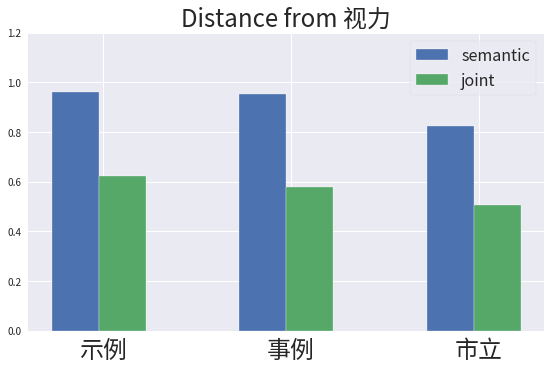

In [102]:
test_similarity("視力", "示例", "事例", "市立", emb1=ch_word2vec, emb2=chm_word2vec, y_max=1.2, filename="noise_ch.jpg")

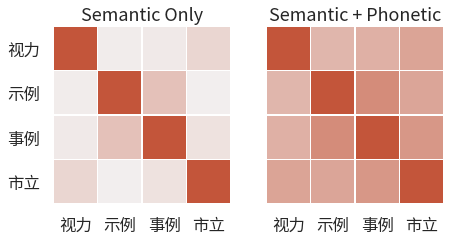

In [138]:
create_embedding_corr(
    ch_word2vec,
    chm_word2vec,
    ["視力", "示例", "事例", "市立"],
    filename="noise_corr_ch.jpg",
)

[0.82614785] [0.85324013]


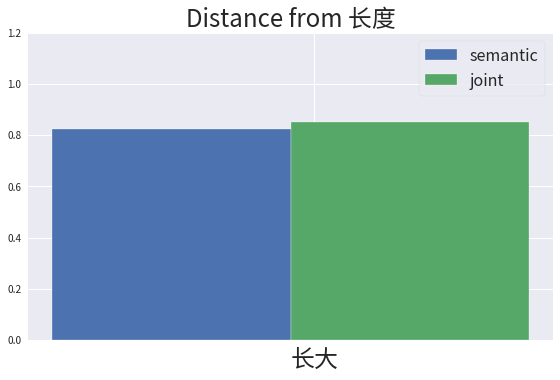

In [176]:
test_similarity("長度", "長大", emb1=ch_word2vec, emb2=chm_word2vec, y_max=1.2, verbose=1)

[0.6362442] [0.6823282]


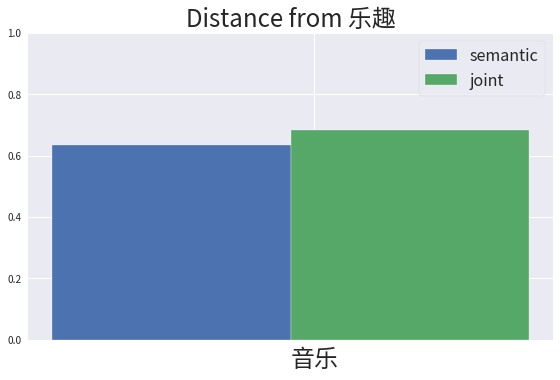

In [177]:
test_similarity("樂趣", "音樂", emb1=ch_word2vec, emb2=chm_word2vec, y_max=1, verbose=1)

[0.84151924] [0.8660332]


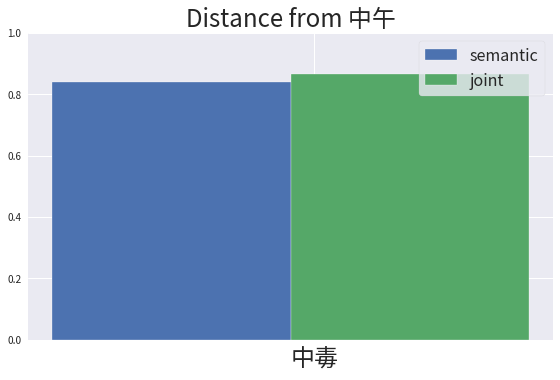

In [178]:
test_similarity("中午", "中毒", emb1=ch_word2vec, emb2=chm_word2vec, y_max=1, verbose=1)

## Japanese

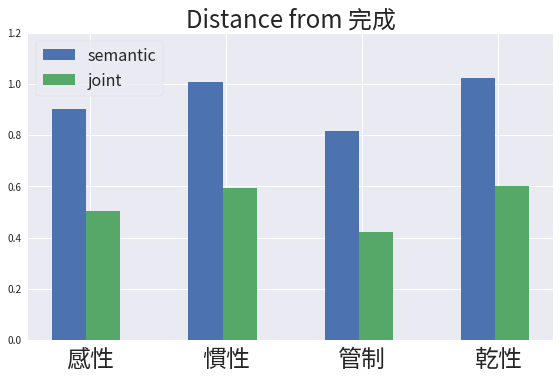

In [74]:
test_similarity("完成", "感性", "慣性", "管制", "乾性", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False, y_max=1.2, filename="noise_jp.jpg")

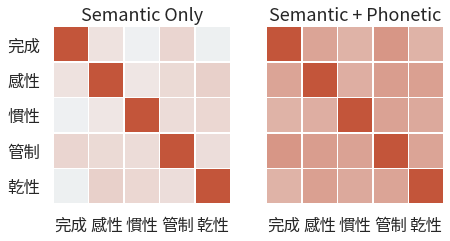

In [139]:
create_embedding_corr(
    jp_word2vec,
    jpm_word2vec,
    ["完成", "感性", "慣性", "管制", "乾性"],
    is_zh=False,
    filename="noise_corr_jp.jpg",
)

In [ ]:
import pykakasi
k= pykakasi.kakasi()
k.convert("生きる")

[0.87939054 0.82956004 0.768724  ] [0.88945603 0.8388028  0.86652976]


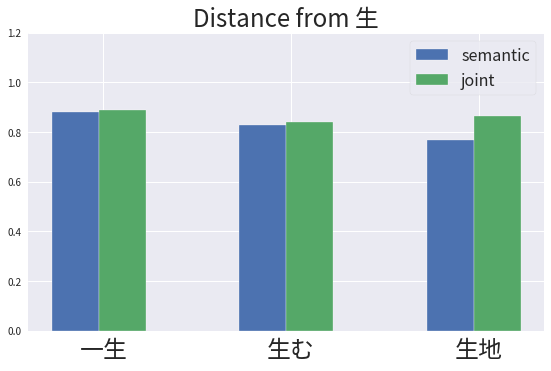

In [155]:
test_similarity("生", "一生", "生む", "生地", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False, verbose=1, y_max=1.2)

[0.65505534] [0.70764434]


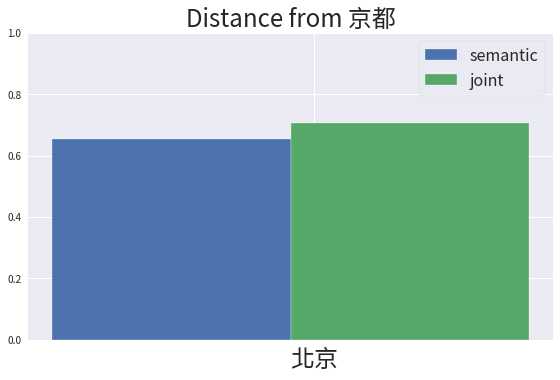

In [180]:
test_similarity("京都", "北京", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False, y_max=1, verbose=1)

# BONUS

[0.55696315] [0.5355674]


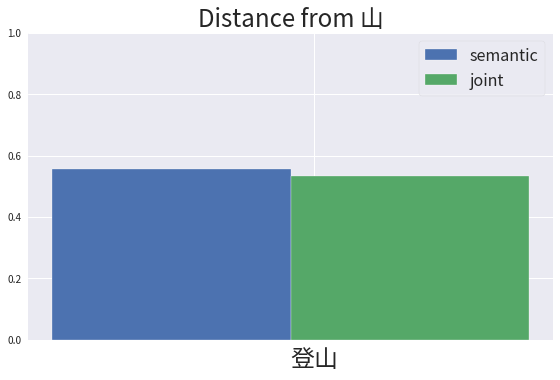

In [181]:
test_similarity("山", "登山", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False, y_max=1, verbose=1)

[0.6273799] [0.5861763]


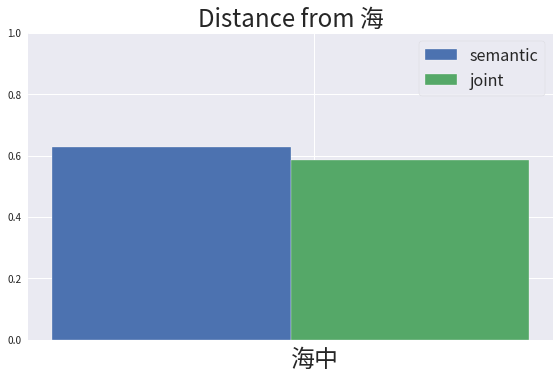

In [182]:
test_similarity("海", "海中", emb1=jp_word2vec, emb2=jpm_word2vec, is_zh=False, y_max=1, verbose=1)